Goal: display the density of the coffee shops in Riga.

Method:
1. Get the coffee shop locations through Google Maps Places API
2. Calculate the distance to the nearest coffee shop on the map of Riga with ~10 meter resolution.

To run this notebook, set the env variable `MAPS_API_KEY` to your Google Maps API key. Suggested way to do it is using the .env file.

In [1]:
import os

import requests
import tempfile

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import polars as pl

import dotenv

dotenv.load_dotenv()

True

# Test out the places API

In [11]:
MAPS_API_KEY = os.getenv('MAPS_API_KEY')

def get_places(lat, long, radius=200):
    '''Function to get the places from google.'''
    result = requests.post(
        "https://places.googleapis.com/v1/places:searchNearby",
        json={
            "includedPrimaryTypes": ["gas_station"],
            "maxResultCount": 20,
            "locationRestriction": {
                "circle": {
                    "center": {
                        "latitude": lat,
                        "longitude": long},
                    "radius": radius
                }
            }
        },
        headers={
            "X-Goog-Api-Key": MAPS_API_KEY,
            "X-Goog-FieldMask": "places.id,places.displayName,places.location,places.businessStatus,places.types,places.rating"
        })
    return result.json()

get_places(56.9786327963213, 24.18334707136689)

{'places': [{'id': 'ChIJnUKjgfbO7kYRhKloM0yRpwU',
   'types': ['gas_station', 'point_of_interest', 'establishment'],
   'location': {'latitude': 56.979147999999995, 'longitude': 24.1844769},
   'rating': 4.3,
   'businessStatus': 'OPERATIONAL',
   'displayName': {'text': 'Circle K', 'languageCode': 'en'}},
  {'id': 'ChIJsfg66FHO7kYRGn0eIjkIC-0',
   'types': ['gas_station',
    'car_wash',
    'convenience_store',
    'car_repair',
    'store',
    'restaurant',
    'food',
    'point_of_interest',
    'establishment'],
   'location': {'latitude': 56.978234799999996,
    'longitude': 24.181965899999998},
   'rating': 4.4,
   'businessStatus': 'OPERATIONAL',
   'displayName': {'text': 'Neste Brīvības', 'languageCode': 'en'}}]}

Challenge #1: There is a restriction on the number of returned results, max 20.
Will have to move through the location range and do multiple queries.

# Get the map to work with

In [12]:
def create_tile_session():
    '''Start the session for downloading the map tiles.'''
    result = requests.post(
        f"https://tile.googleapis.com/v1/createSession?key={MAPS_API_KEY}",
        json={
            "mapType": "roadmap",
            "language": "lv-LV",
            "region": "EU"
        })
    return result.json()

tile_session_data = create_tile_session()
tile_session_token = tile_session_data['session']
tile_session_data

{'session': 'AJVsH2xjng0q3GQodoAfXfyzvbQDZHB-oAnKWG8nuvEnRre0paEQObPm8CllCk5O3fThMh-vWBck5p9Pycf6oWILdA',
 'expiry': '1715772870',
 'tileWidth': 256,
 'imageFormat': 'png',
 'tileHeight': 256}

4642 2509


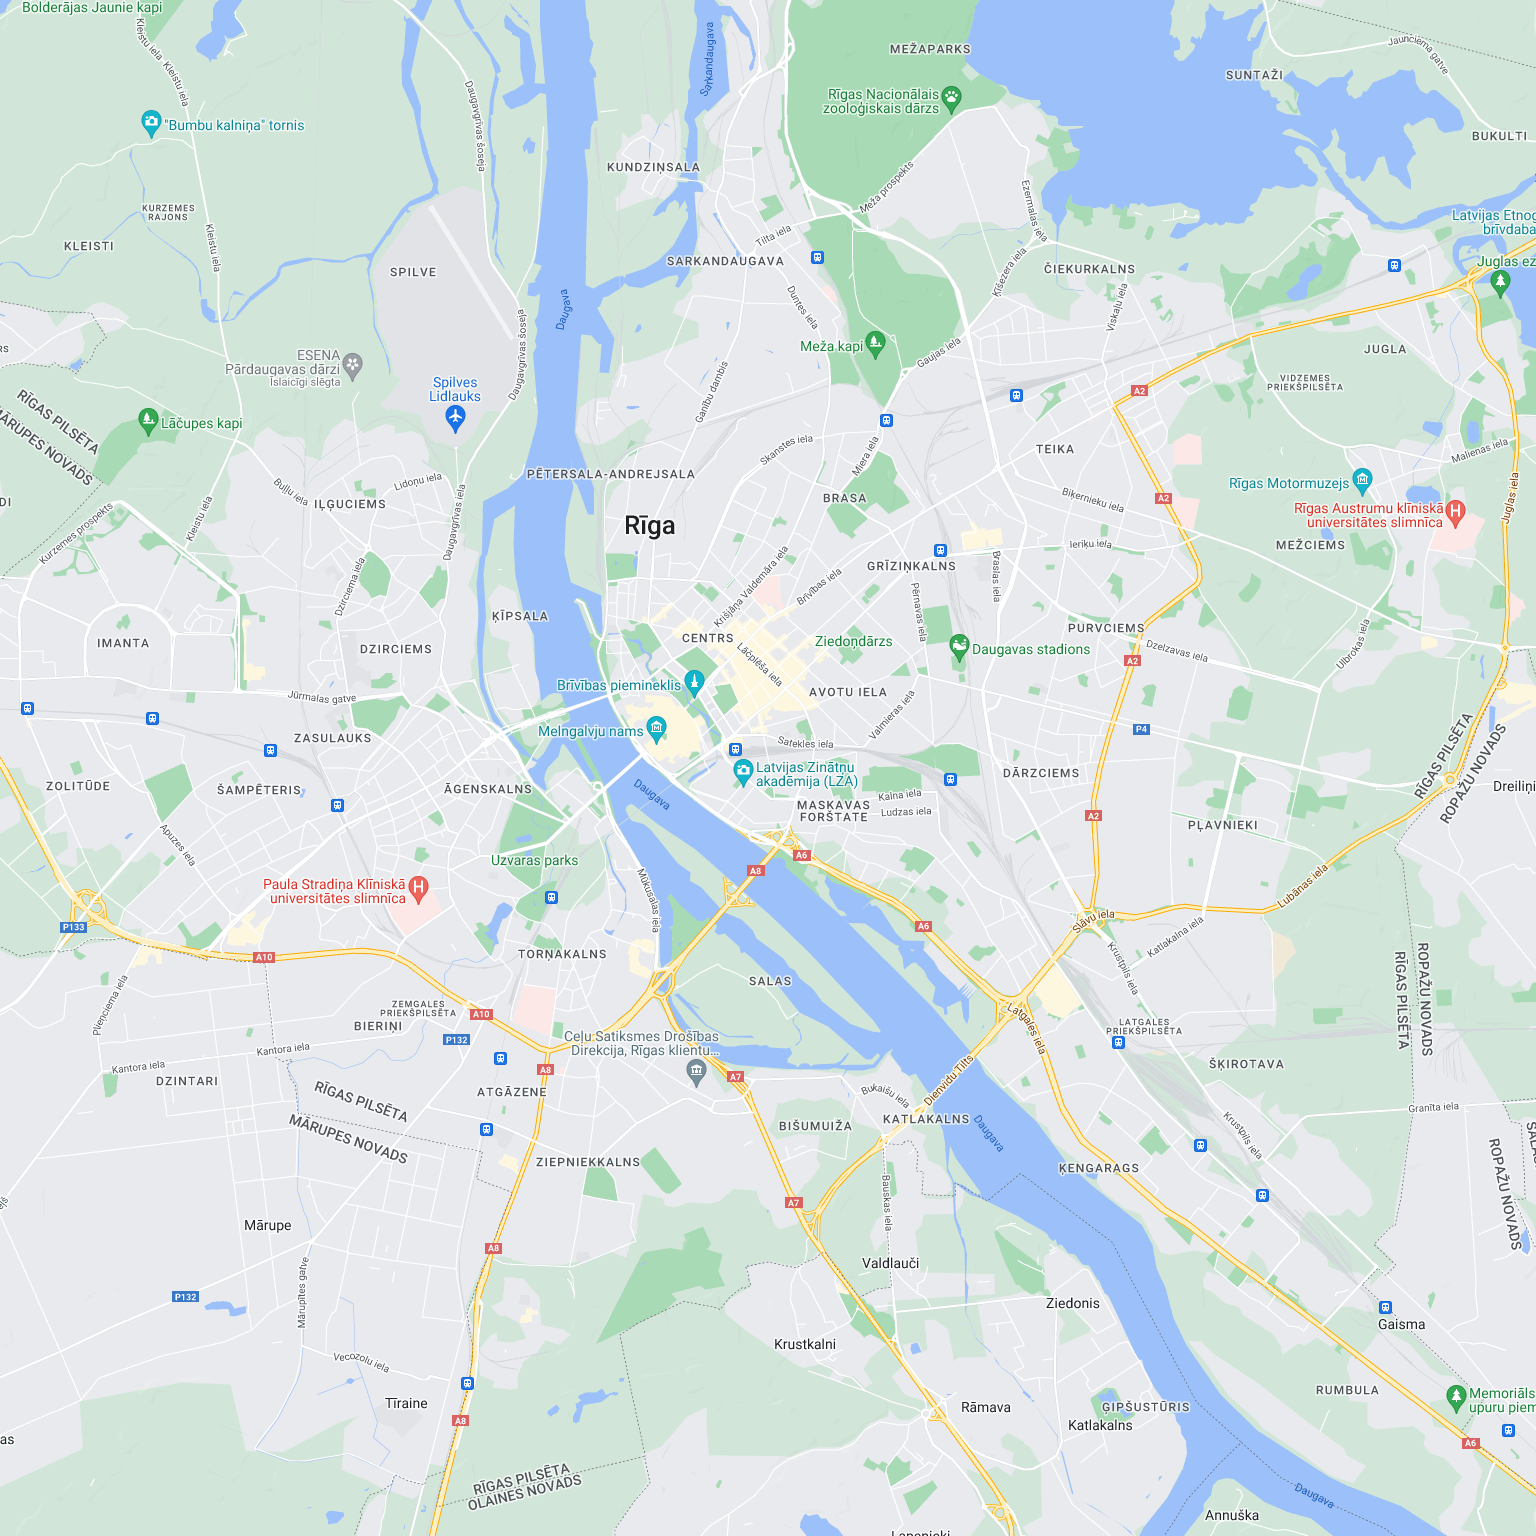

In [13]:
def get_tile(z, x, y, token):
    '''Download the tile to a temporary file and reat into image.
See https://developers.google.com/maps/documentation/javascript/coordinates#tile-coordinates
    '''
    assert z >= 0 and z <= 22
    result = requests.get(f"https://tile.googleapis.com/v1/2dtiles/{z}/{x}/{y}?session={token}&key={MAPS_API_KEY}")
    fname = tempfile.mktemp()
    with open(fname, "bw") as outf:
        for chunk in result.iter_content(chunk_size=128):
            outf.write(chunk)
    return Image.open(fname)


zoom_level = 13

# Upper-left corner that we are interested in.
target_lat, target_lon = 57.003338688341785, 24.022965005482522

# Convert latitude and longitude to Google Maps World coordinates.
# See https://developers.google.com/maps/documentation/javascript/coordinates#world-coordinates
world_x = (target_lon + 180) / 360
world_y = (1 - np.log(np.tan(np.radians(target_lat)) + 1 / np.cos(np.radians(target_lat))) / np.pi) / 2

# Get pixel coordinates.
tile_size = 256
pixel_x = world_x * 2 ** zoom_level * tile_size
pixel_y = world_y * 2 ** zoom_level * tile_size

# Get tile coordinates.
tile_x = int(pixel_x // tile_size)
tile_y = int(pixel_y // tile_size)

print(tile_x, tile_y)

# Download the tiles.
x_range = 6
y_range = 6
tiles = [
    get_tile(zoom_level, tile_x + x, tile_y + y, tile_session_token)
    for x in range(x_range)
    for y in range(y_range)
]
tiles

# Concatenate into a single map.
map = Image.new('RGB', (256*x_range, 256*y_range))

for x in range(x_range):
    for y in range(y_range):
        map.paste(tiles[x*x_range + y], (x*256, y*256))
map

In [14]:
# Get the coordinates of the upper left and lower right corners of the map.
def tile_to_coords(tile_x, tile_y):
    coords = (tile_x, tile_y)
    # Convert back to pixel coordinates.
    coords = (
        coords[0] * tile_size,
        coords[1] * tile_size
    )
    # Convert back to world coordinates.
    coords = (
        coords[0] / 2 ** zoom_level / tile_size,
        coords[1] / 2 ** zoom_level / tile_size
    )
    # Convert back to latitude and longitude.
    coords = (
        360 * coords[0] - 180,
        360 * np.arctan(np.exp(np.pi * (1 - 2 * coords[1]))) / np.pi - 90
    )
    return coords[1], coords[0]

upper_left = tile_to_coords(tile_x, tile_y)
lower_right = tile_to_coords(tile_x + x_range, tile_y + y_range)

upper_left, lower_right

((57.01681401739111, 23.994140625), (56.87299566379642, 24.2578125))

In [15]:
def coords_to_pixel(lat, long):
    '''Convert the coordinate location to the pixel on our map.'''
    if lat < lower_right[0] or lat > upper_left[0] or long < upper_left[1] or long > lower_right[1]:
        return None, None
    x = (long - upper_left[1]) / (lower_right[1] - upper_left[1])
    y = (upper_left[0] - lat) / (upper_left[0] - lower_right[0])
    return int(x * map.size[0]), int(y * map.size[1])

def pixel_to_coords(x, y):
    '''Convert the image pixel location to coordinates.'''
    x = x / map.size[0]
    y = y / map.size[1]
    long = x * (lower_right[1] - upper_left[1]) + upper_left[1]
    lat = upper_left[0] - y * (upper_left[0] - lower_right[0])
    return lat, long

print(coords_to_pixel(56.95365263429106, 24.11351183058847))
print(pixel_to_coords(420, 550))

(695, 674)
(56.96531656004926, 24.066238403320312)


## Plan out the locations 

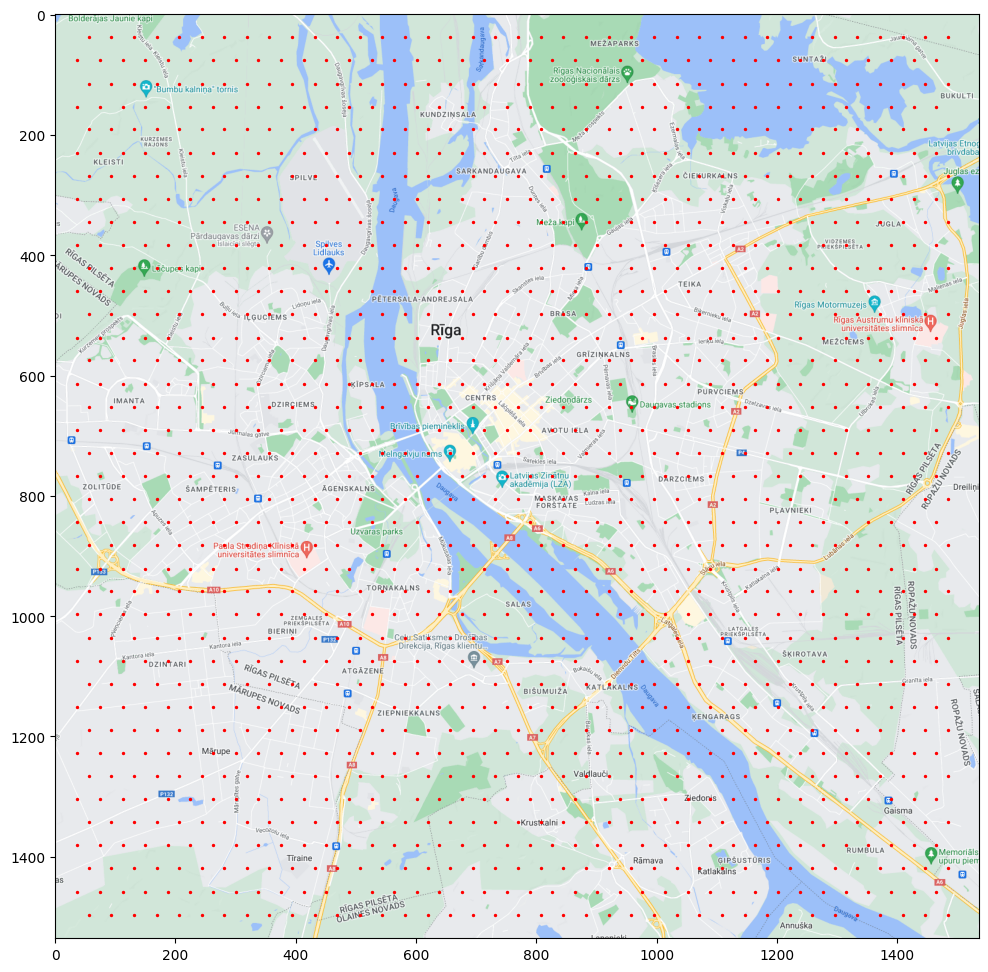

In [20]:
# The coordinate difference of about 100 meters in our range.
lat_step = -(0.1 / 111.32)
long_step = (0.1 / 62.0132)

plt.figure(figsize=(12, 12))
plt.imshow(map)

location_centers = []

for ox in range(1, 40):
    for oy in range(1, 40):
        lat = upper_left[0] + ox*4*lat_step
        # Shift each second row a bit.
        long = upper_left[1] + oy*4*long_step + (
            2*long_step if ox % 2 == 1 else 0)
        if lat < lower_right[0] or long > lower_right[1]:
            continue
        location_centers.append((lat, long))

        x, y = coords_to_pixel(lat, long)
        plt.scatter(x, y, color="red", s=2)

plt.show()

# Get the data

Will make a request for a 200-meter radius for each location and save the results separately.

Then will preprocess them, removing dublictes.

In [21]:
raw_places = []

for loc in location_centers:
    raw_places.append(get_places(*loc, 400))

len(raw_places)

1521

In [25]:
raw_places[350]

{}

In [26]:
places_data = {
    'id': [],
    'name': [],
    'latitude': [],
    'longitude': [],
    'x': [],
    'y': [],
    'rating': [],
    'businessStatus': [],
    'primaryType': [],
    'types': []
}
seen_ids = set()

for data in raw_places:
    places = data.get('places', [])
    for place in places:
        if place['id'] in seen_ids:
            continue
        seen_ids.add(place['id'])
        places_data['id'].append(place['id'])
        places_data['name'].append(place['displayName']['text'])
        places_data['rating'].append(place.get('rating', None))
        places_data['businessStatus'].append(place.get('businessStatus', None))
        place_types = place.get('types', None)
        places_data['primaryType'].append(place_types[0] if place_types else None)
        places_data['types'].append(place_types)

        lat = place['location']['latitude']
        lon = place['location']['longitude']
        x, y = coords_to_pixel(lat, lon)
        places_data['latitude'].append(lat)
        places_data['longitude'].append(lon)
        places_data['x'].append(x)
        places_data['y'].append(y)

all_places = pl.DataFrame(places_data)
all_places.head(10)

shape: (10, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ id         ┆ name       ┆ latitude  ┆ longitude ┆ … ┆ rating ┆ businessS ┆ primaryTy ┆ types     │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---    ┆ tatus     ┆ pe        ┆ ---       │
│ str        ┆ str        ┆ f64       ┆ f64       ┆   ┆ f64    ┆ ---       ┆ ---       ┆ list[str] │
│            ┆            ┆           ┆           ┆   ┆        ┆ str       ┆ str       ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ ChIJe-o9bH ┆ Virši Sark ┆ 56.997831 ┆ 24.116533 ┆ … ┆ 4.4    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ HP7kYR111_ ┆ andaugava, ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ N0YU-CI    ┆ DUS        ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJ_UGAwH ┆ DUS        ┆ 56.993433 ┆ 24.122333 ┆ … ┆ 4.4    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ TP7kYREM99 ┆ ,,Circle K ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ 3ScDwe0    ┆ Sarkandaug ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆ ava"       ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJtfbRru ┆ Viada      ┆ 56.993576 ┆ 24.173476 ┆ … ┆ 4.1    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ PO7kYR8TkK ┆            ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ vhcMyfQ    ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJEf3vEp ┆ CrossChem  ┆ 56.989447 ┆ 24.11197  ┆ … ┆ 4.1    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ 7P7kYRkR4o ┆ AdBlue     ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ ltYWklA    ┆ uzpildes   ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆ stacij…    ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJYVPv65 ┆ Latvijas   ┆ 56.988374 ┆ 24.11786  ┆ … ┆ 4.2    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ _P7kYRyD-X ┆ Nafta 09.  ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ zIp7isI    ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ "coffee_s │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ hop", ……  │
│ ChIJUbUARD ┆ VIADA      ┆ 56.988622 ┆ 24.129766 ┆ … ┆ 4.4    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ LP7kYRN28C ┆            ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ XHAYarA    ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJgVhI1e ┆ Straujupīt ┆ 56.990989 ┆ 24.169767 ┆ … ┆ null   ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ LO7kYRx_lO ┆ e          ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ 4_UQWXQ    ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ "point_of │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ _intere…  │
│ ChIJ-Z4BOK ┆ Circle K   ┆ 56.989416 ┆ 24.243369 ┆ … ┆ 3.9    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ DO7kYR_Qlp ┆            ┆           ┆           ┆   ┆        ┆ AL        ┆ on        ┆ tion",    │
│ 5kLoUTk    ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ "car_wash │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆           ┆ ", … "e…  │
│ ChIJGTRjFv ┆ Neste      ┆ 56.988071 ┆ 24.130489 ┆ … ┆ 4.6    ┆ OPERATION ┆ gas_stati ┆ ["gas_sta │
│ HJ7kYR5v7w ┆            ┆           ┆      

In [40]:
# Drop places with wrong business status and too low ratings.
valid_places = all_places.filter(
    pl.col('businessStatus') == "OPERATIONAL",
    # pl.col('rating') > 4.0,
).drop_nulls()
valid_places.shape

(147, 10)

# Generate density map

Will work with a 100 meter grid. For every grid cell, assign the distance to the closest coffee shop as the value, rounded down to 20 meters.

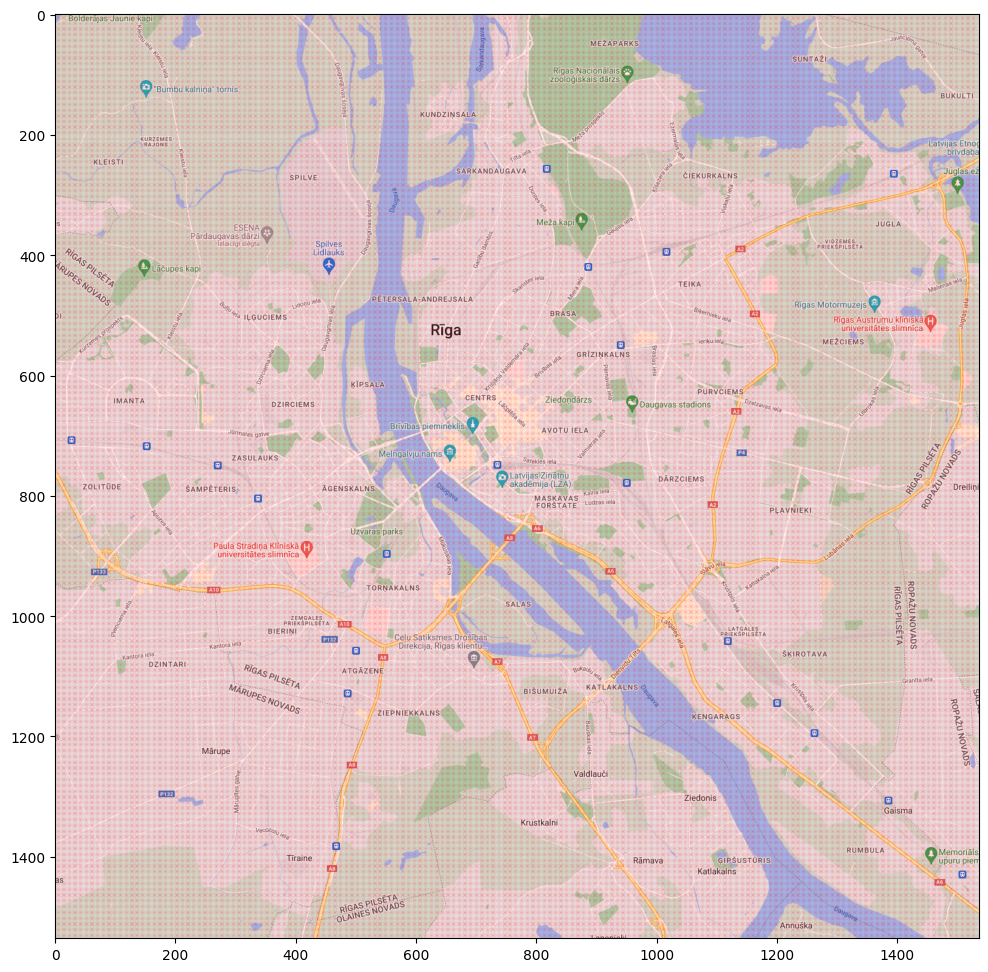

In [41]:
grid_lat_step = lat_step
grid_long_step = long_step

grid_lat_values = np.arange(upper_left[0], lower_right[0], grid_lat_step)
grid_long_values = np.arange(upper_left[1], lower_right[1], grid_long_step)

# density_grid = np.meshgrid(grid_lat_values, grid_long_values)

# density_grid

density_grid_coords = [
    (lat, long)
    for lat in grid_lat_values
    for long in grid_long_values
]
density_grid_pixels = [coords_to_pixel(*c) for c in density_grid_coords]

plt.figure(figsize=(12, 12))
plt.imshow(map)

plt.scatter([p[0] for p in density_grid_pixels], [p[1] for p in density_grid_pixels], color="red", alpha=0.05)
plt.show()

In [42]:
def closest_place(lat, long):
    '''Get the distance to the closest place based on the given coordinates.'''
    closest_dist = 100000000
    for cf_lat, cf_long in zip(valid_places['latitude'], valid_places['longitude']):
        dist_sq = ((lat - cf_lat) / grid_lat_step)**2 + ((long - cf_long) / grid_long_step)**2
        if dist_sq < closest_dist:
            closest_dist = dist_sq
    return np.sqrt(closest_dist)

density_grid_values = np.array([
    closest_place(*c)
    for c in density_grid_coords
])

# density_grid_values /= np.mean(density_grid_values)

density_grid_values[-10:]

array([10.71983756, 10.50652766, 10.38553463, 10.36009342, 10.43090322,
       10.59603454, 10.85118216, 11.19019036, 11.60571266, 12.08986239])

## Final image

In [43]:
density_grid_values_2d = np.array(density_grid_values).reshape(
    len(grid_lat_values), len(grid_long_values))

In [44]:
density_mesh = np.array(density_grid_pixels)
density_x = pl.Series(density_mesh[:,0]).unique()
density_y = pl.Series(density_mesh[:,1]).unique()
density_x.shape, density_y.shape

((164,), (161,))

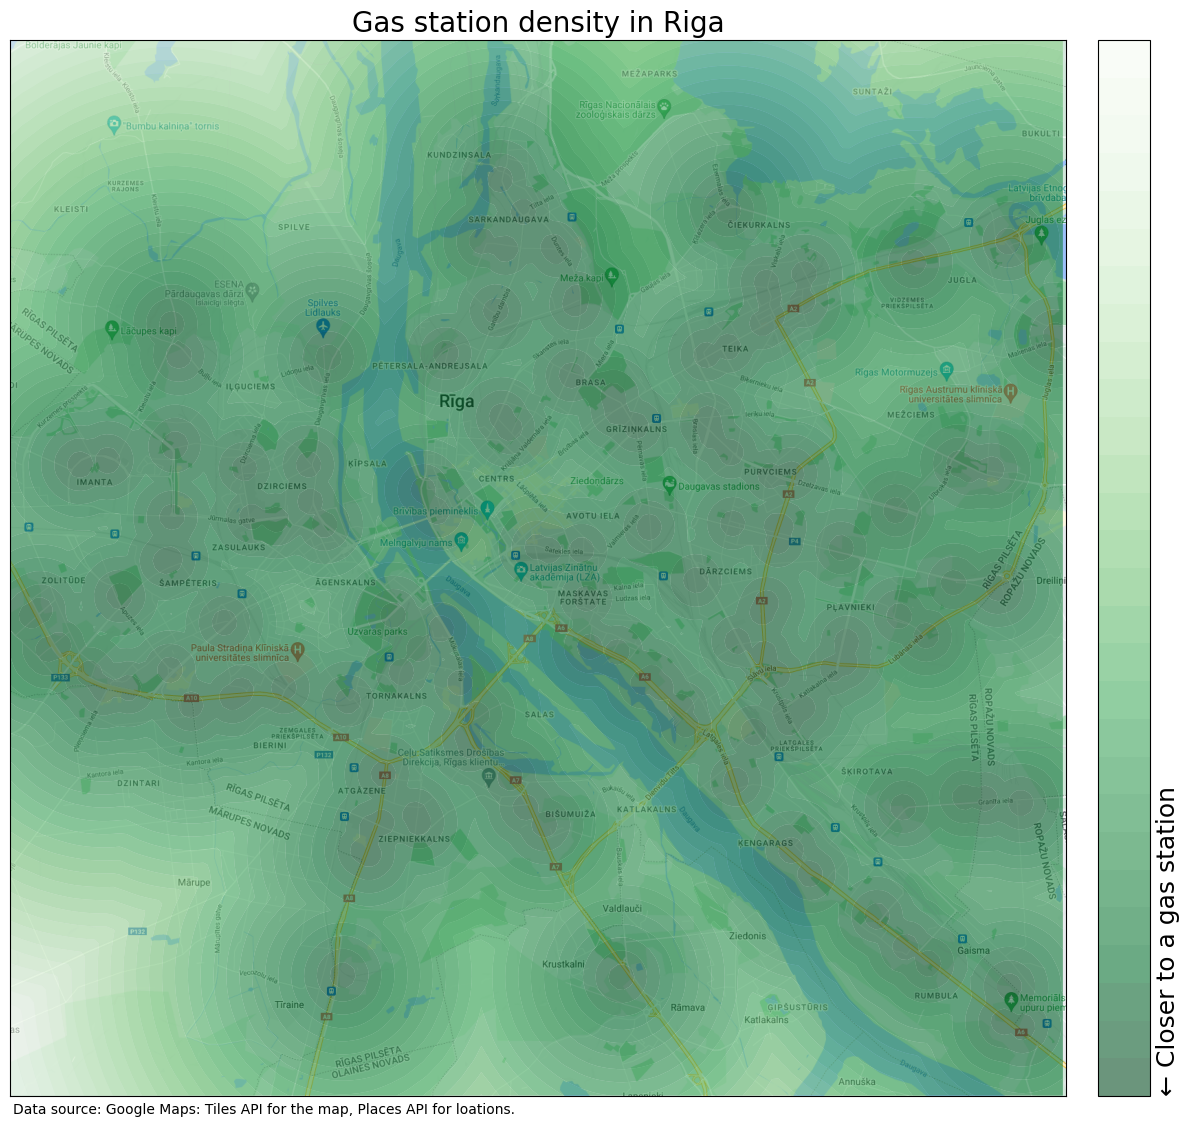

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.close('all')

plt.figure(figsize=(12, 12))
im = plt.imshow(map)
plt.xticks([])
plt.yticks([])
plt.contourf(density_x, density_y, density_grid_values_2d, cmap="Greens_r",alpha=0.58, levels=32, antialiased=True, linestyles="dotted")
plt.title("Gas station density in Riga", fontsize=20)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(cmap="Greens_r", mappable=None, cax=cax, ticklocation="right")
cbar.ax.set_yticks([])
#Adjust the font size of colorbar ticks
cbar.set_label("← Closer to a gas station", fontsize=18, loc="bottom")

plt.figtext(0.015, 0.045, "Data source: Google Maps: Tiles API for the map, Places API for loations.")

plt.tight_layout()
# plt.show()